### This is so far the best shot at the whole thing. Keep this one in mind

In [1]:
import json
import pandas as pd
import keras
from keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Configurations
batch_size = 64
num_channels = 3  # RGB images have 3 channels
num_classes = 2
image_size = (128, 96)  # Resize to save memory
latent_dim = 128

# Paths to data
image_dir = '../FP/Data/HAM/ham_images'  # Directory containing images
csv_path = '../FP/Experiments/two_class_metadata.csv'  # Path to CSV file

# Load data from CSV
df = pd.read_csv(csv_path)

# Extract image IDs and classes
image_ids = df['image_id'].values
labels = df['class'].values

# Encode labels to integers then to one-hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(integer_encoded, num_classes=num_classes)

# Define function to get full image path
def get_image_path(image_id):
    return f"{image_dir}/{image_id}.jpg"  

# Load and process images
def process_image(image_id):
    full_path = get_image_path(image_id)
    img = load_img(full_path, target_size=image_size, color_mode='rgb')  # Load as RGB
    img_array = img_to_array(img).astype("float32") / 255.0
    return img_array

# Create datasets
all_images = np.array([process_image(image_id) for image_id in image_ids])
all_labels = one_hot_labels

# Ensure the images have 4 dimensions (batch_size, height, width, channels)
# RGB images already have 3 channels, no need for additional dimension
all_images = np.reshape(all_images, (-1, image_size[0], image_size[1], num_channels))

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Print data shapes for confirmation
print(f"Shape of images: {all_images.shape}")
print(f"Shape of labels: {all_labels.shape}")

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

print(f"Generator input channels: {generator_in_channels}")
print(f"Discriminator input channels: {discriminator_in_channels}")

# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((*image_size, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense((image_size[0] // 4) * (image_size[1] // 4) * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((image_size[0] // 4, image_size[1] // 4, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(num_channels, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed = 1337
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    def summary(self, *args, **kwargs):
        self.generator.summary(*args, **kwargs)
        self.discriminator.summary(*args, **kwargs)

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data
        batch_size = tf.shape(real_images)[0]

        # Ensure one_hot_labels is float32
        one_hot_labels = tf.cast(one_hot_labels, tf.float32)
        
        # Expand labels to match the shape of images for concatenation.
        image_one_hot_labels = tf.reshape(one_hot_labels, (-1, 1, 1, num_classes))
        image_one_hot_labels = tf.tile(image_one_hot_labels, [1, image_size[0], image_size[1], 1])

        # Sample random points in the latent space and concatenate the labels.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed)
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=-1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=-1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Assemble labels discriminating real from fake images.
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), seed=self.seed)
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], axis=-1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

    def get_config(self):
        config = super().get_config()
        config.update({
            'latent_dim': self.latent_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        latent_dim = config['latent_dim']
        # Recreate models manually or adapt this part to load actual model structures.
        discriminator = keras.Sequential(
            [
                keras.layers.InputLayer((128, 96, 5)),  # Image dimensions + label channels
                layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(negative_slope=0.2),
                layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(negative_slope=0.2),
                layers.GlobalMaxPooling2D(),
                layers.Dense(1),
            ],
            name="discriminator",
        )

        generator = keras.Sequential(
            [
                keras.layers.InputLayer((latent_dim + 2,)),  # Latent space dimension + label channels
                layers.Dense((128 // 4) * (96 // 4) * (latent_dim + 2)),
                layers.LeakyReLU(negative_slope=0.2),
                layers.Reshape((128 // 4, 96 // 4, latent_dim + 2)),
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(negative_slope=0.2),
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(negative_slope=0.2),
                layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
            ],
            name="generator",
        )
        return cls(discriminator, generator, latent_dim)

    def save(self, filepath, overwrite=True, include_optimizer=True):
        config = {
            'class_name': self.__class__.__name__,
            'config': self.get_config()
        }
        with open(filepath + '_config.json', 'w') as f:
            json.dump(config, f)

        self.generator.save_weights(filepath + '_generator.weights.h5', overwrite=overwrite)
        self.discriminator.save_weights(filepath + '_discriminator.weights.h5', overwrite=overwrite)

    @classmethod
    def load(cls, filepath):
        with open(filepath + '_config.json', 'r') as f:
            config = json.load(f)

        model = cls.from_config(config['config'])
        model.generator.load_weights(filepath + '_generator.weights.h5')
        model.discriminator.load_weights(filepath + '_discriminator.weights.h5')
        return model

# Instantiate and compile the ConditionalGAN model
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0006),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0006),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Fit the model to the dataset
cond_gan.fit(dataset, epochs=50)

# Save the model
cond_gan.save('cond_gan_model')

# Load the model
loaded_model = ConditionalGAN.load('cond_gan_model')

# Recompile the model after loading
loaded_model.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0006),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0006),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Verify the model structure
print(loaded_model.summary())

Shape of images: (10015, 128, 96, 3)
Shape of labels: (10015, 2)
Generator input channels: 130
Discriminator input channels: 5
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 617s 4s/step - d_loss: 0.5349 - g_loss: 1.1835
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 593s 4s/step - d_loss: 0.5183 - g_loss: 1.4401
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 586s 4s/step - d_loss: 0.2077 - g_loss: 3.8509
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 590s 4s/step - d_loss: 0.0288 - g_loss: 4.0485
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 588s 4s/step - d_loss: 0.0218 - g_loss: 4.1960
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 598s 4s/step - d_loss: 0.1120 - g_loss: 4.0952
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1042s 7s/step - d_loss: 0.0388 - g_loss: 5.4481
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1053s 7s/step - d_loss: 0.0395 - g_loss: 4.8294
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - d_loss: 9.2135e-04 - g_loss: 7.4630
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - d_loss: 0.0178 - g_loss: 7.7

Model: "conditional_gan_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator (Sequential)      │ ?                      │        76,929 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ ?                      │    13,626,499 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,703,428 (52.27 MB)

 Trainable params: 13,703,428 (52.27 MB)

 Non-trainable params: 0 (0.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


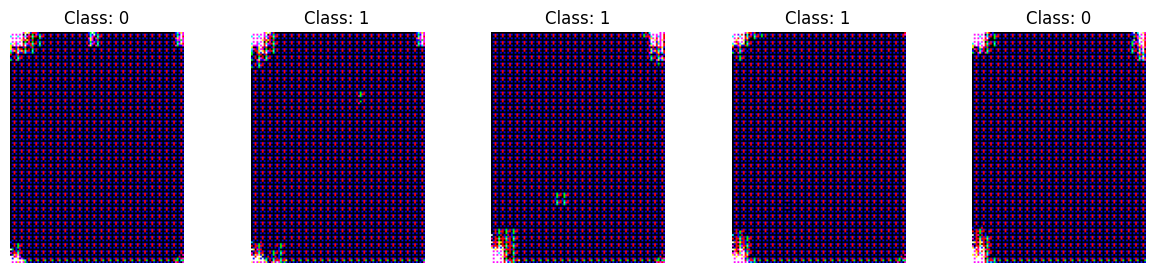

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Function to generate images
def generate_images(generator, latent_dim, num_classes, num_images=1, class_labels=None):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))

    # If no class labels are provided, use random ones
    if class_labels is None:
        class_labels = np.random.randint(0, num_classes, num_images)
    class_labels = to_categorical(class_labels, num_classes=num_classes)

    # Combine the latent vectors with the class labels
    generator_input = np.concatenate([random_latent_vectors, class_labels], axis=1)

    # Generate images
    generated_images = generator.predict(generator_input)

    # Scale images to range [0, 1]
    generated_images = (generated_images * 255).astype(np.uint8)

    return generated_images, class_labels

# Load the saved ConditionalGAN model
loaded_model = ConditionalGAN.load('cond_gan_model')

# Generate a few images
num_images_to_generate = 5
generated_images, class_labels = generate_images(
    loaded_model.generator, 
    latent_dim=latent_dim, 
    num_classes=num_classes, 
    num_images=num_images_to_generate
)

# Plot the generated images
fig, axes = plt.subplots(1, num_images_to_generate, figsize=(15, 3))
for i, (img, label) in enumerate(zip(generated_images, class_labels)):
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {np.argmax(label)}")
    axes[i].axis('off')
plt.show()
